# Punctuation restoration

The sequence tagging with BERT-like models is quite common among researchers nowdays
+ For example, the following research https://www.researchgate.net/publication/348618580_Automatic_punctuation_restoration_with_BERT_models (WordPiece + BERT uncased) suggests tagging words with labes `EMPTY`, `PERIOD`, `COMMA` etc. when they are followed by a punctuation symbol or not. The minor downside of suggested approach is that they use full-fledged dictionary, which may be memory-consuming. 
+ The overlapping sliding window is suggested to deal with sentences of the size exceeding input length. Due to overelap, for the same pieces we may get several predictions. The mean of them will be taken.

1. First of all, in my research I'd like to concentrate on correcting commas in a sentence, so I may limit my output data to "COMMA" and "EMP" for now
2. I gonna try LSTM approach first - BERT seems to be too large for the task. Moreover, it can let us feed into sentences of an arbitary length.

1. To train the model from scratch, we have to perform conversion of BPE encoded data to a form, in which our objective would be to predict, wheither a token is followed by a comma/period.

What else can be added:
- Not use lower() on corpus?
    + Done
- Proper sentence splitting
    + Done
- Cleanse messy punctuation from original corpus - as long as I aim this model to work in my telegram assistant, I can expect myself not using strange symbols.
- Add more texts
    + Added russian literature corpus along with my collected news corpus.

## Step 1: common preparation of textual data

Yttm will behave nicely with text with commas, separated by space from both sides. This approach misses some information, like common word endings that are followed by a comma, yet it may be simplier to implement.

**Important**: this shall be done for every training case. At the evaluation step text shall not contain any commas

In [1]:
import youtokentome as yttm
import pandas as pd
import numpy as np
import re

In [2]:
data = pd.read_parquet("text_corpus.parquet")

In [3]:
corpus = [text.replace(",", " ,") for text in data.text]

In [150]:
# the archive shall be pre-downloaded
# https://github.com/natasha/corus#load_taiga_proza
from corus import load_taiga_proza_metas, load_taiga_proza
from pathlib import Path

path = Path("~/datasets/corus/taiga/proza_ru.zip").expanduser()
if not path.parent.exists():
    path.parent.mkdir(parents=True, exist_ok=False)

metas = load_taiga_proza_metas(path, offset=0, count=60000)
records = load_taiga_proza(path, metas, offset=0, count=60000)

In [151]:
corpus.extend([record.text.replace(",", " ,") for record in records])

In [155]:
len(corpus)

30000

## Step 2: creating encoder
For such modified text data bpe encoder shall be trained separately, of course.

In [69]:
TOTAL_WORDS = 5000
BPE_MODEL_PATH = "bpe.yttm"


def create_bpe_tokenizer_from_scratch(corpus, train_data_path="yttm_train_data.txt"):
    with open(train_data_path, "w") as _file:
        _file.writelines(corpus)
    # Training model
    # (data, model, vocab_size, coverage, n_threads=-1, pad_id=0, unk_id=1, bos_id=2, eos_id=3)
    return yttm.BPE.train(
        data=train_data_path, vocab_size=TOTAL_WORDS, model=BPE_MODEL_PATH, n_threads=6
    )

In [70]:
bpe = create_bpe_tokenizer_from_scratch(" \n ".join(corpus))

In [71]:
COMMA = bpe.encode(" ,")[0]  # COMMA token shall be fixed after each re-training

In [72]:
print(" ".join(bpe.vocab())[:600])

<PAD> <UNK> <BOS> <EOS> ▁ о е а и н т с л р в к м д у п , . я ь ы з г б ч й - ж х ш ю ц щ э Н " В С § П О А ! ё И К М ф Т Д Я Р : Б Л ' Е Г У Э З Ч ) Х ( e Ф * Ц ъ 1 0 a t o Ш i Ж n r 2 Ю s Ъ Ь h l u p 9 5 d 3 ; 4 « » y m c Ы 8 6 7 w Щ / g Й I f b k — v S ~ = A x T z M Ё C P | N D V H B E R O X } { L [ ] q W F % G + – j Y $ K @ ? J U \ & ” “   # Z € Q … ^ > < ‒ ­ ‘ ​ • ̆ ‎ ` ‚ ’ _ ️ · ▁, ▁п ▁с ▁н ▁в то ▁о но ▁и ра ко ст ро ен ▁по ал го ▁д ка ▁м ре ▁не ▁на ▁- ▁б ли ла ет ▁т ть ло ни ри ▁з ▁ч во на ▁у ва ся ер ны ль ки да ем ▁за сь ру ▁к ле ▁е ▁ко те ▁что ти ми ви ди не ну же ▁ра та ▁ка ▁про ▁--


## Step 3: comma encoding algorithm

Now as we have a way to create a numerical representation of our textual data, we have to process it in a way to 
1. Remove all commas (our model shall not know where they are originally, just try to predict)
2. Save information about commas in a way we will be able to calculate loss between a model's prediction and actual data.

In short, our algorithm will be the following:
1. At the position of each word followed by a comma we will put label 1
2. The following comma token will be stripped out
3. At the end, lengthes of encoded sentence and label list shall be equal.

In [73]:
def encode_commas(sent):
    # for-loopish version can be optimized
    result = []
    for idx, token in enumerate(sent):
        if idx == len(sent) - 1:
            # no comma checking for last token
            result.append(0)
        else:
            if token == COMMA:
                continue
            elif sent[idx + 1] == COMMA:
                result.append(1)
            else:
                result.append(0)
    assert sum(result) > 0, "Sentence MUST contain at least 1 comma"
    return result

## Step 4: creating train data


1. Encode a sentence
2. Encode commas
3. Strip commas from encoded sentence
4. Ensure lengthes are equal

In [88]:
from razdel import sentenize
from tqdm import tqdm

In [156]:
# we dont need sents without commas
corpus_of_sents_with_commas = [
    sent.strip()
    for text in corpus
    for sent in [s.text for s in sentenize(text)]
    if "," in sent
]

In [79]:
encoded_corpus = []
tags = []
for idx, sent in enumerate(corpus_of_sents_with_commas):
    encoded_sentence = bpe.encode(sent)
    if not COMMA in encoded_sentence:
        continue
    if encoded_sentence[0] == COMMA:  # issue of period separation
        continue
    taglist = encode_commas(encoded_sentence)
    encoded_sentence = list(filter(lambda x: x != COMMA, encoded_sentence))
    es_len = len(encoded_sentence)
    tl_len = len(taglist)
    if es_len > 200:
        continue  # I keep no hope the net will manage to comprehend such a lenthy chunk
    if es_len != tl_len:
        print(f"Lengthes do not match at {idx}: sentence has {es_len} and taglist has {tl_len}")
        continue
    encoded_corpus.append(encoded_sentence)
    tags.append(taglist)

Lengthes do not match at 46016: sentence has 54 and taglist has 55
Lengthes do not match at 102000: sentence has 58 and taglist has 59
Lengthes do not match at 108587: sentence has 31 and taglist has 32
Lengthes do not match at 192253: sentence has 20 and taglist has 21
Lengthes do not match at 304714: sentence has 3 and taglist has 4
Lengthes do not match at 309075: sentence has 27 and taglist has 28
Lengthes do not match at 451750: sentence has 49 and taglist has 50
Lengthes do not match at 580462: sentence has 6 and taglist has 7
Lengthes do not match at 1024632: sentence has 27 and taglist has 28
Lengthes do not match at 1031208: sentence has 10 and taglist has 11
Lengthes do not match at 1349990: sentence has 5 and taglist has 6
Lengthes do not match at 1758026: sentence has 6 and taglist has 7
Lengthes do not match at 1837744: sentence has 191 and taglist has 192
Lengthes do not match at 2008310: sentence has 17 and taglist has 18
Lengthes do not match at 2367613: sentence has 35

In [80]:
len(encoded_corpus)

3206882

In [81]:
assert len(tags) == len(encoded_corpus)

## Step 5: creating model

In [82]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [83]:
EMBEDDING_DIM = 24
HIDDEN_DIM = 24
VOCAB_SIZE = TOTAL_WORDS
TAGSET_SIZE = 2

In [84]:
class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()

        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    #         self.lstm            = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)
    #         self.hidden2tag      = nn.Linear(2*hidden_dim, tagset_size)

    def forward(self, words):
        embeds = self.word_embeddings(words)
        lstm_out, _ = self.lstm(embeds.view(len(words), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(words), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)

        return tag_scores

    def predict_tags(self, words):
        with torch.no_grad():
            tags_pred = model(words).numpy()
            tags_pred = np.argmax(tags_pred, axis=1)

        return tags_pred

In [85]:
# weighted loss function
zerocount = sum([len(a) - sum(a) for a in tags])
onecount = sum([sum(a) for a in tags])

class_divs = torch.tensor([zerocount, onecount], dtype=float)
norm = torch.norm(class_divs, p=2, dim=0).detach()

class_divs = class_divs.div(norm.expand_as(class_divs))
class_weights = torch.ones(2)

class_weights /= class_divs

print(class_weights.detach())

tensor([ 1.0032, 12.5483])


In [86]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAGSET_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
# loss_function = nn.NLLLoss(class_weights)

In [152]:
class_weights

tensor([ 1.0032, 12.5483])

In [157]:
loss_function = nn.NLLLoss()

In [159]:
from livelossplot import PlotLosses

liveplot = PlotLosses()

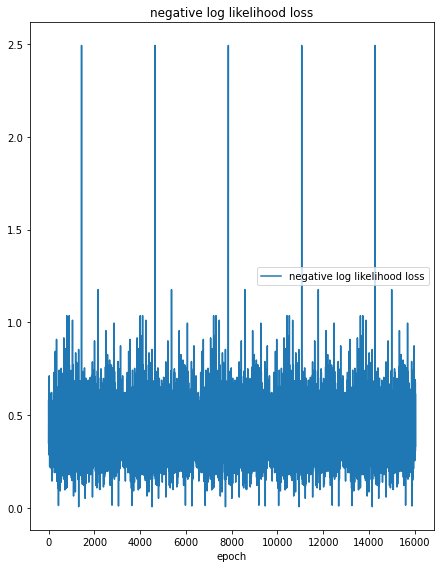

negative log likelihood loss
	negative log likelihood loss 	 (min:    0.006, max:    2.494, cur:    0.310)
Iteration 3206000 of epoch 4


In [160]:
for epoch in range(5):
    for i, (text, taglist) in enumerate(zip(encoded_corpus, tags)):
        model.train()
        model.zero_grad()
        text = torch.tensor(text)
        taglist = torch.tensor(taglist)
        tag_scores = model(text)

        loss = loss_function(tag_scores, taglist)
        loss.backward()
        optimizer.step()

        if i % 1000 == 0:
            l = loss.detach().numpy()
            liveplot.update({"negative log likelihood loss": l})
            liveplot.draw()
            print(f"Iteration {i} of epoch {epoch}")

## Step 6: evaluation and inverse transformation

Now when we have a model predicting commas for us, it would be useful to inject those predictions right into our sentence.

idea: assume the pre-existing commas are correct, and fill in only missing ones.

In [161]:
def fill_in_commas(text):
    # ensure text accidentaly has no spaces in a row
    text = re.sub("\s{2,}", " ", text)
    # encode text by bpe
    encoded_text = bpe.encode(text)
    # get predicted labels
    with torch.no_grad():
        predicted_tags = model.predict_tags(torch.tensor(encoded_text))
    # inject commas
    result = []
    for token, label in zip(encoded_text, predicted_tags):
        result.append(token)
        if label:
            result.append(COMMA)
    result = bpe.decode(result)[0]
    # return normal spacing
    result = result.replace(" ,", ",")

    # remove commas in the middle of words (this actually shall not be the case but nevertheless)
    result = re.sub("(?<=\w),(?=\w)", "", result)
    # same with commas right before punctuations
    result = re.sub(",(?=[.?!;:])", "", result)

    result = result.replace(",,", ",")
    return result

In [162]:
fill_in_commas("Я не знаю что это такое однако могу предположить что что-то плохое.")

'Я не знаю, что это такое, однако, могу предположить, что что-то плохое.'

In [163]:
fill_in_commas("Ой, ну это - да; надо убираться больше а ещё почухать его.")

'Ой, ну, это - да; надо, убираться, больше, а ещё почухать, его.'

In [164]:
fill_in_commas("Всё это очень долгое сложное неинтересное и непонятное.")

'Всё, это очень долгое, сложное, неинтересное, и непонятное.'

## Saving the model

In [165]:
torch.save(model.state_dict(), "lstm_tagger.pt")
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAGSET_SIZE)

model.load_state_dict(torch.load("lstm_tagger.pt"))
model.eval()

LSTMTagger(
  (word_embeddings): Embedding(5000, 24)
  (lstm): LSTM(24, 24)
  (hidden2tag): Linear(in_features=24, out_features=2, bias=True)
)